# Anticipez les besoins en consommation électrique de bâtiments

Utiliser les données disponible sur https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking  pour prédire es consommations énérgétiques, ainsi que les émissions en CO2 pour la ville de Seattle

## Partie 1 : Analyse exploratoire

### Quelques imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from dython.nominal import associations
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import json
import warnings
sns.set()

warnings.filterwarnings('ignore')

### Chargement des données
On remarque qu'il existe 2 CSVs différents à télécharger, un pour les données 2015, et un autre pour les données 2016
Pour expliquer notre démarche, on choisit de faire la modélisation purement sur les données 2016, on testera notre modèle final sur les données 2015 pour voir sa pertinence. 
Pour ce faire, on devra appliqué le même nettoyage aux deux données, ainsi que les mêmes transformations

In [2]:
data_2015 = pd.read_csv('data/2015-building-energy-benchmarking.csv')
data_2016 = pd.read_csv('data/2016-building-energy-benchmarking.csv')

In [3]:
data_2015.shape

(3340, 47)

In [4]:
data_2016.shape

(3376, 46)

On remarque aussi des fichiers JSON qui contiennent la description par colonne, on va les charger pour pouvoir accéder à la description par colonne

In [5]:
desc_2015 = json.load(open('data/socrata_metadata_2015-building-energy-benchmarking.json'))
desc_2016 = json.load(open('data/socrata_metadata_2016-building-energy-benchmarking.json'))

In [6]:
data_2015.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [7]:
data_2016.head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


### Homogénisation des données entre les deux sources de données
On va d'abord faire en sorte d'avoir les mêmes colonnes dans les deux CSVs
On commence donc par voir les colonnes communes entres les deux dataframes

In [8]:
common_columns = set(data_2015.columns) & set(data_2016.columns)

In [9]:
print('Common columns :')
for col in common_columns:
    print('\t' + str(col))

Common columns :
	PrimaryPropertyType
	SteamUse(kBtu)
	Outlier
	ComplianceStatus
	SiteEUIWN(kBtu/sf)
	SecondLargestPropertyUseTypeGFA
	NumberofFloors
	PropertyGFABuilding(s)
	YearsENERGYSTARCertified
	Electricity(kBtu)
	SourceEUI(kBtu/sf)
	SecondLargestPropertyUseType
	ListOfAllPropertyUseTypes
	LargestPropertyUseTypeGFA
	DataYear
	YearBuilt
	PropertyGFATotal
	ThirdLargestPropertyUseType
	NaturalGas(therms)
	TaxParcelIdentificationNumber
	NaturalGas(kBtu)
	SiteEnergyUse(kBtu)
	ENERGYSTARScore
	LargestPropertyUseType
	SourceEUIWN(kBtu/sf)
	OSEBuildingID
	Neighborhood
	SiteEnergyUseWN(kBtu)
	ThirdLargestPropertyUseTypeGFA
	PropertyGFAParking
	Electricity(kWh)
	PropertyName
	NumberofBuildings
	BuildingType
	SiteEUI(kBtu/sf)
	CouncilDistrictCode
	DefaultData


On regarde les colonnes qui existent dans l'une ou dans l'autre des deux dataframes

In [10]:
columns_2015_only = set(data_2015.columns) - set(data_2016.columns) 

In [11]:
print('2015 columns not in 2016:')
for col in columns_2015_only:
    print('\t' + str(col))

2015 columns not in 2016:
	Seattle Police Department Micro Community Policing Plan Areas
	Location
	Comment
	GHGEmissions(MetricTonsCO2e)
	2010 Census Tracts
	GHGEmissionsIntensity(kgCO2e/ft2)
	City Council Districts
	Zip Codes
	SPD Beats
	OtherFuelUse(kBtu)


In [12]:
columns_2016_only = set(data_2016.columns) - set(data_2015.columns) 
print('2016 columns not in 2015:')
for col in columns_2016_only:
    print('\t' + str(col))

2016 columns not in 2015:
	City
	Longitude
	State
	TotalGHGEmissions
	GHGEmissionsIntensity
	Comments
	ZipCode
	Latitude
	Address


Certaines colonnes sont évidents à renommer d'après la description des colonnes

In [13]:
data_2015.rename(columns={
    'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
    'Comment':'Comments',
    'Zip Codes':'ZipCode',
    'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
}, inplace=True)

In [14]:
columns_2015_only = set(data_2015.columns) - set(data_2016.columns) 
print('2015 columns not in 2016:')
for col in columns_2015_only:
    print('\t' + str(col))
columns_2016_only = set(data_2016.columns) - set(data_2015.columns) 
print('2016 columns not in 2015:')
for col in columns_2016_only:
    print('\t' + str(col))
    

2015 columns not in 2016:
	Seattle Police Department Micro Community Policing Plan Areas
	Location
	2010 Census Tracts
	City Council Districts
	SPD Beats
	OtherFuelUse(kBtu)
2016 columns not in 2015:
	City
	Longitude
	State
	Latitude
	Address


Les colonnes restantes sont soit redondates (concernant l'adress, latitude longitude ..) ou n'apportent pas d'éléments explicatifs, ces dernières sont en majorités présentes en 2015 mais ont disparu en  2016, on peut supposer que ces colonnes ne seront plus existentes dans les années à venir, et donc on peut les enlever

In [15]:
data_2015.drop(columns=set(data_2015.columns) - set(data_2016.columns), inplace=True)

In [16]:
data_2016.drop(columns=set(data_2016.columns) - set(data_2015.columns), inplace=True)

### Nettoyage des données

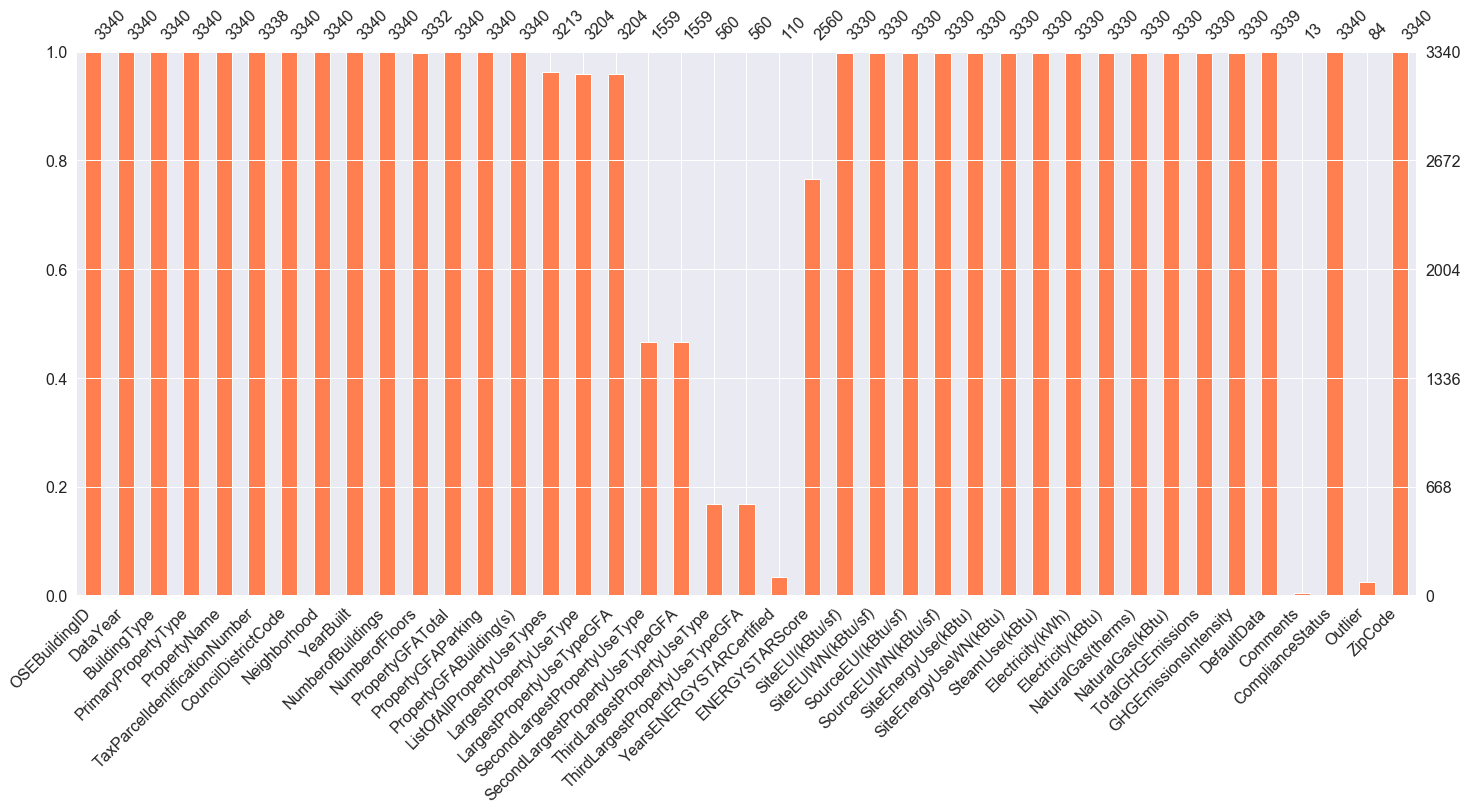

In [17]:
msno.bar(data_2015, color='coral')

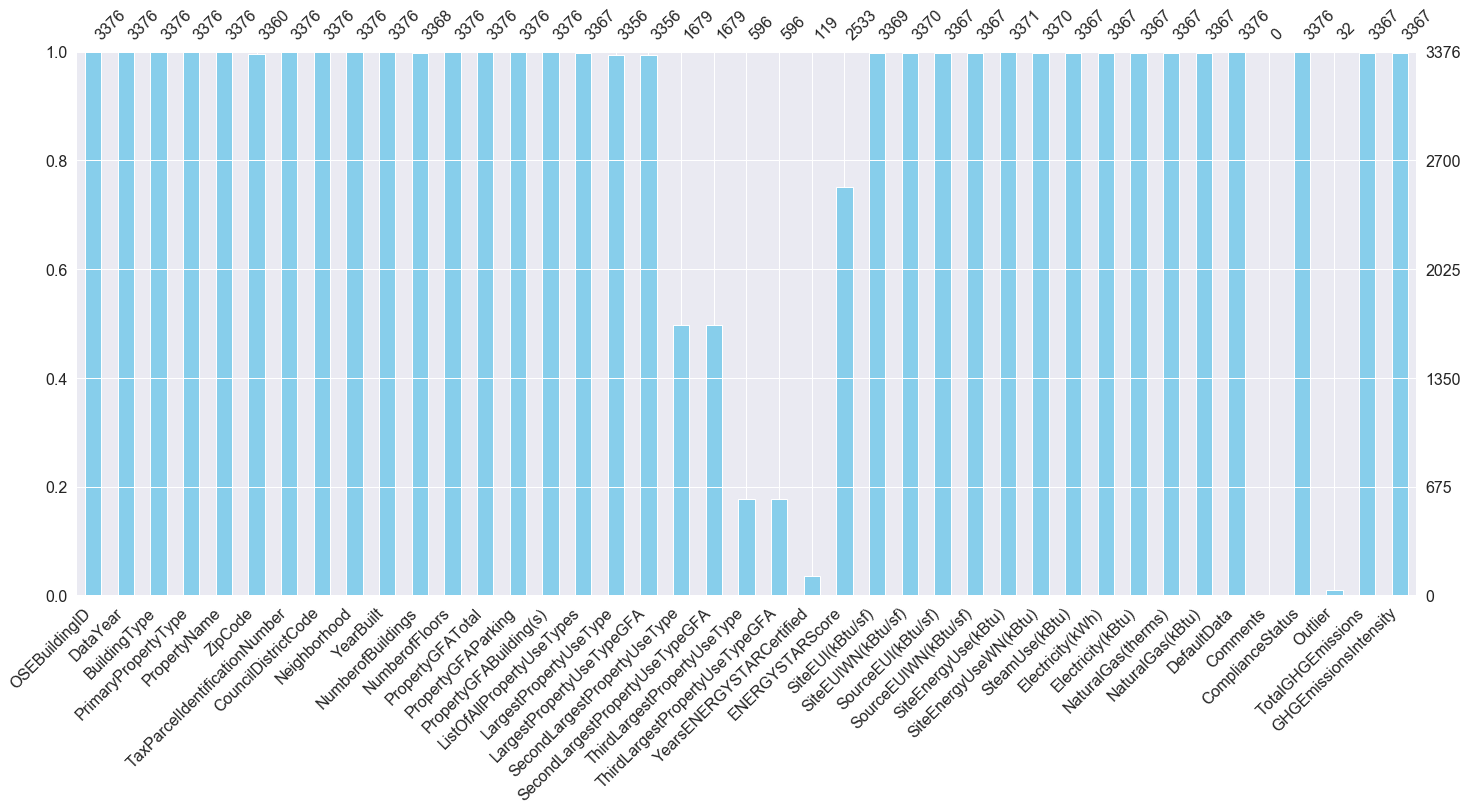

In [18]:
msno.bar(data_2016, color='skyblue')

In [19]:
 # On va voir la description par colonne pour pouvoir nettoyer des colonnes
for col_desc in desc_2016['columns']:
    name = col_desc.get('name')
    if name and name in data_2016.columns:
        print('{}: \n\t{}'.format(name, col_desc.get('description')))

OSEBuildingID: 
	A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
DataYear: 
	Calendar year (January-December) represented by each data record.
BuildingType: 
	City of Seattle building type classification.
PrimaryPropertyType: 
	The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
PropertyName: 
	Official or common property name as entered in EPA’s Portfolio Manager.
ZipCode: 
	Property zip
TaxParcelIdentificationNumber: 
	Property King County PIN 
CouncilDistrictCode: 
	Property City of Seattle council district.
Neighborhood: 
	Property neighborhood area defined by the City of Seattle Department of Neighborhoods.
YearBuilt: 
	Year in which a property was constructed or underwent a complete renovation.
NumberofBuildings: 
	Number of buildings

On peut enlever les valeurs trop manquantes (à moins de 50%) et qui ne seront pas utiles pour notre modélisation

In [20]:
data_2016 = msno.nullity_filter(data_2016, filter='top', p=0.5)

Comme expliqué plus haut, on continue à garder les mêmes colonnes entre 2015 et 2016

In [21]:
data_2015.drop(columns=set(data_2015.columns) - set(data_2016.columns), inplace=True)

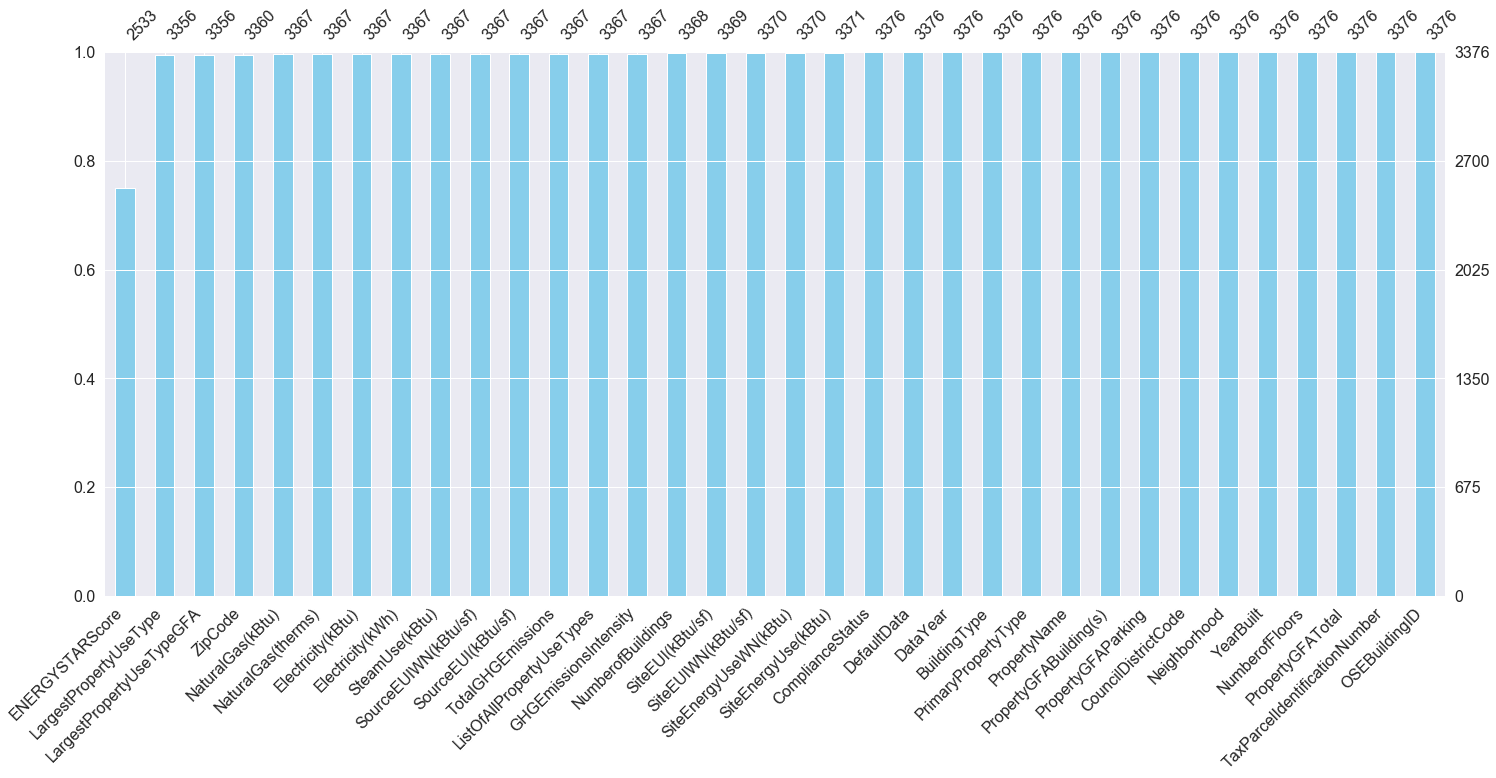

In [22]:
msno.bar(data_2016, sort='ascending', color='skyblue')

Quelques données sont des ids comme OSEBuildingID, TaxParcelIdentificationNumber, PropertyName
Et D'autres sont redondantes ListOfAllPropertyUseTypes(fusion de toutes la liste des propriétés, on peut donc les enlever)

In [23]:
columns_to_drop = ['OSEBuildingID', 'TaxParcelIdentificationNumber', 'ListOfAllPropertyUseTypes', 'PropertyName']

data_2016.drop(columns=columns_to_drop, inplace=True)
# On applique la même transformation aux données 2015
data_2015.drop(columns=columns_to_drop, inplace=True)

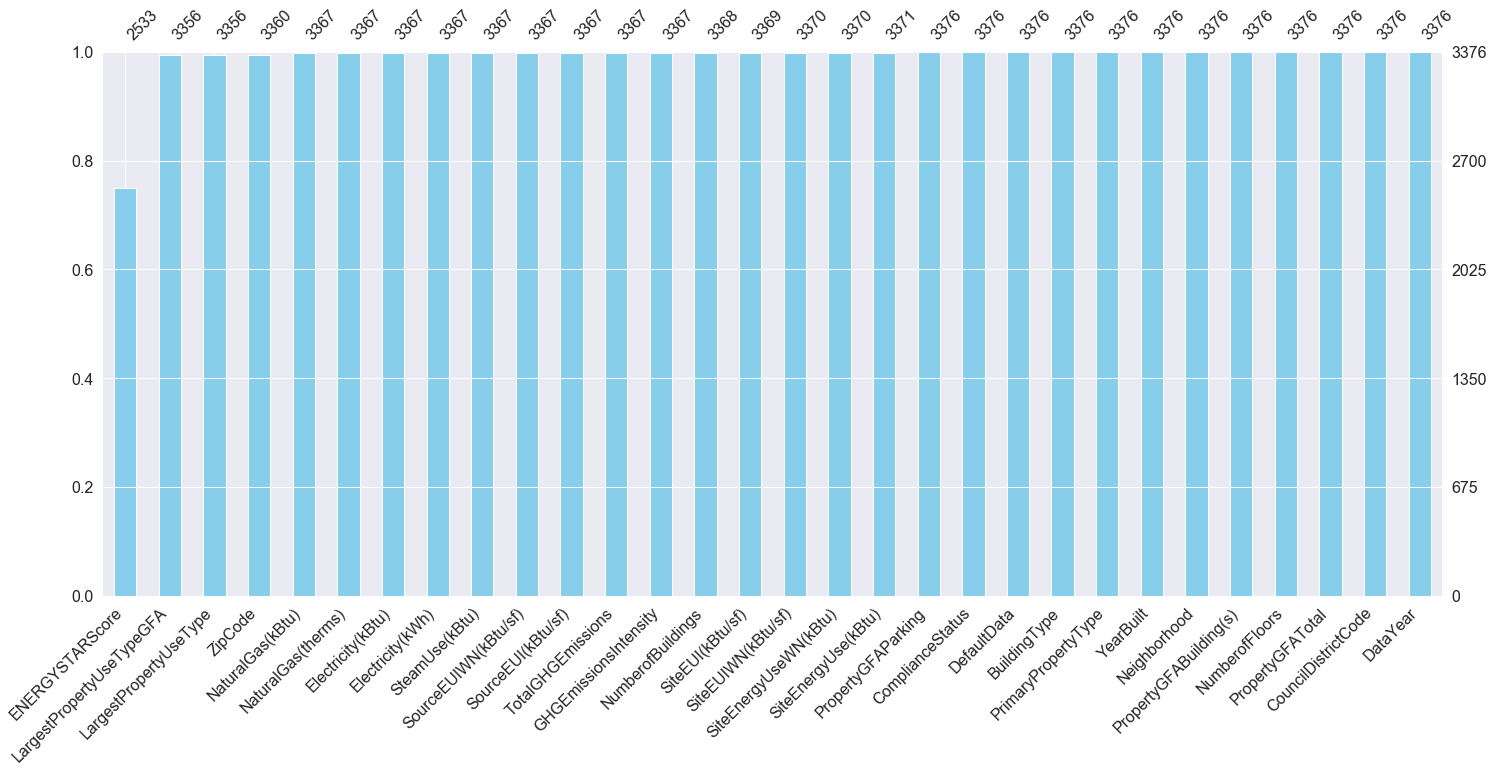

In [24]:
msno.bar(data_2016, sort='ascending', color='skyblue')

La colonne ComplianceStatus dit si le building a respecté les benchmarking à fournir ou pas, les données pour les bâtiments non compliant peuvent être erronées

In [25]:
data_2016 = data_2016[data_2016['ComplianceStatus'] == 'Compliant']
data_2015 = data_2015[data_2015['ComplianceStatus'] == 'Compliant']

In [26]:
data_2016.shape

(3211, 30)

la colonne DataYear  représente juste l'année de la donnée, ce n'est pas très intressant, on va changer la colonne YearBuilt par une colonne Building Age qui est plus intéressante pour notre étude (surtout que cet age va changer année par année et impactera probablement la modélisation)

In [27]:
data_2016['Building Age'] = data_2016['DataYear'] - data_2016['YearBuilt']
data_2015['Building Age'] = data_2015['DataYear'] - data_2015['YearBuilt']

data_2016.drop(columns=['DataYear', 'YearBuilt'], inplace=True)
data_2015.drop(columns=['DataYear', 'YearBuilt'], inplace=True)

On va aussi nettoyer les colonnes contenant une seule valeur, ça ne sera pas trop utile à l'analyse

In [28]:
columns_to_clean = []
for col in data_2016.columns:
    if len(data_2016[col].unique()) == 1:
        print('Cleaning column {} with unique value {}'.format(col, data_2016[col].unique()[0]))
        columns_to_clean.append(col)
data_2016.drop(columns=columns_to_clean, inplace=True)
# on applique le même nettoyage aux données 2015
data_2015.drop(columns=set(data_2015.columns) - set(data_2016.columns), inplace=True)

Cleaning column DefaultData with unique value False
Cleaning column ComplianceStatus with unique value Compliant


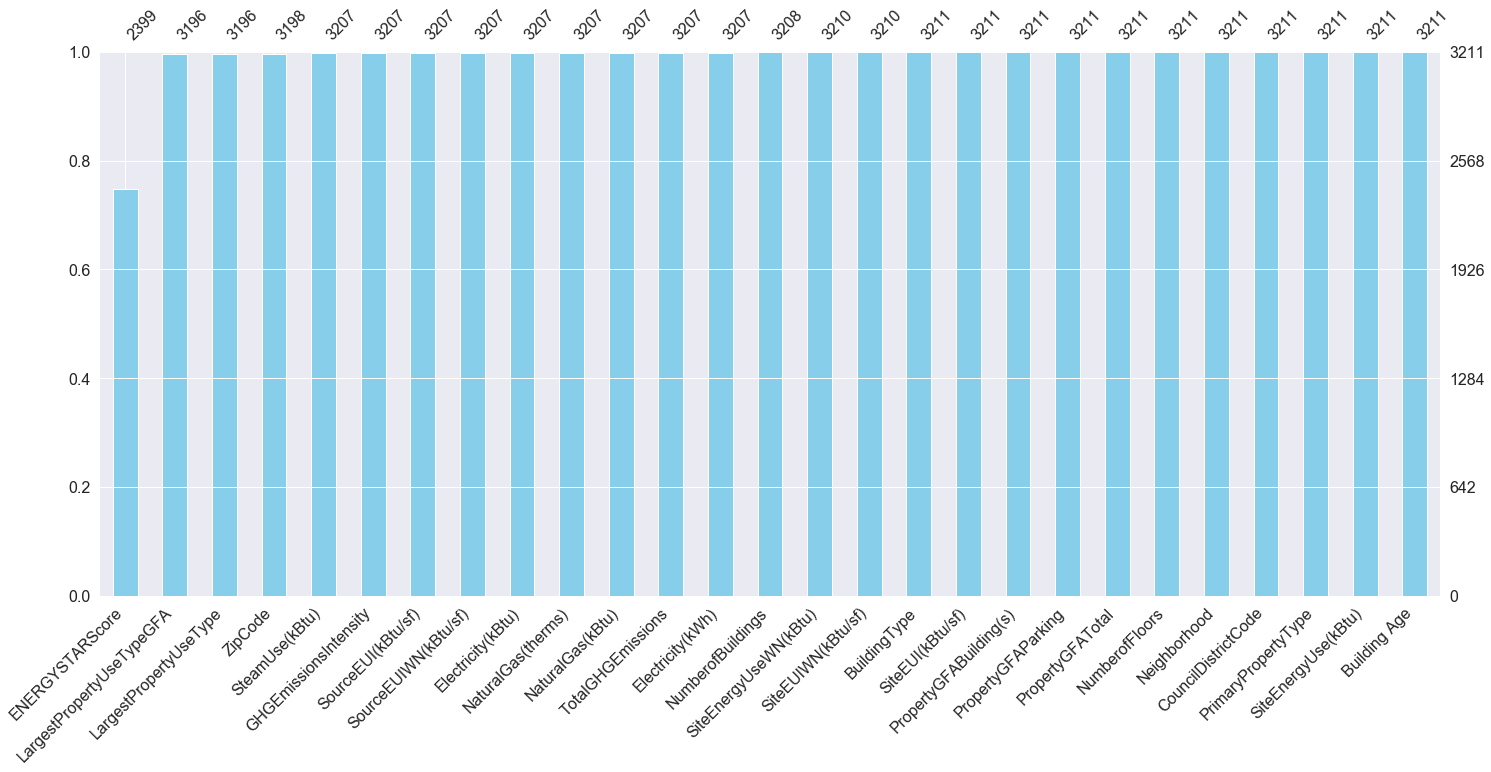

In [29]:
msno.bar(data_2016, sort='ascending', color='skyblue')

En seconde étape, on va nettoyer les données fortement corrélées entre elles, pour réduire la dimension

In [30]:
data_2016.dtypes

BuildingType                  object
PrimaryPropertyType           object
ZipCode                      float64
CouncilDistrictCode            int64
Neighborhood                  object
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFATotal               int64
PropertyGFAParking             int64
PropertyGFABuilding(s)         int64
LargestPropertyUseType        object
LargestPropertyUseTypeGFA    float64
ENERGYSTARScore              float64
SiteEUI(kBtu/sf)             float64
SiteEUIWN(kBtu/sf)           float64
SourceEUI(kBtu/sf)           float64
SourceEUIWN(kBtu/sf)         float64
SiteEnergyUse(kBtu)          float64
SiteEnergyUseWN(kBtu)        float64
SteamUse(kBtu)               float64
Electricity(kWh)             float64
Electricity(kBtu)            float64
NaturalGas(therms)           float64
NaturalGas(kBtu)             float64
TotalGHGEmissions            float64
GHGEmissionsIntensity        float64
Building Age                   int64
d

In [31]:
# on va enlever les duplicats des données énergetiques pour commencer
def correlation_matrix(df):
    categorical_columns = list(df.select_dtypes(include='category').columns)
    copy = df.dropna(how='any', axis=0)
    copy = copy[categorical_columns + list(copy.select_dtypes(include=[np.number]).columns.values)]
    associations(copy,
                 figsize=(20,15),
                 theil_u=False, 
                 nominal_columns=categorical_columns,
                 nan_strategy='drop_samples')

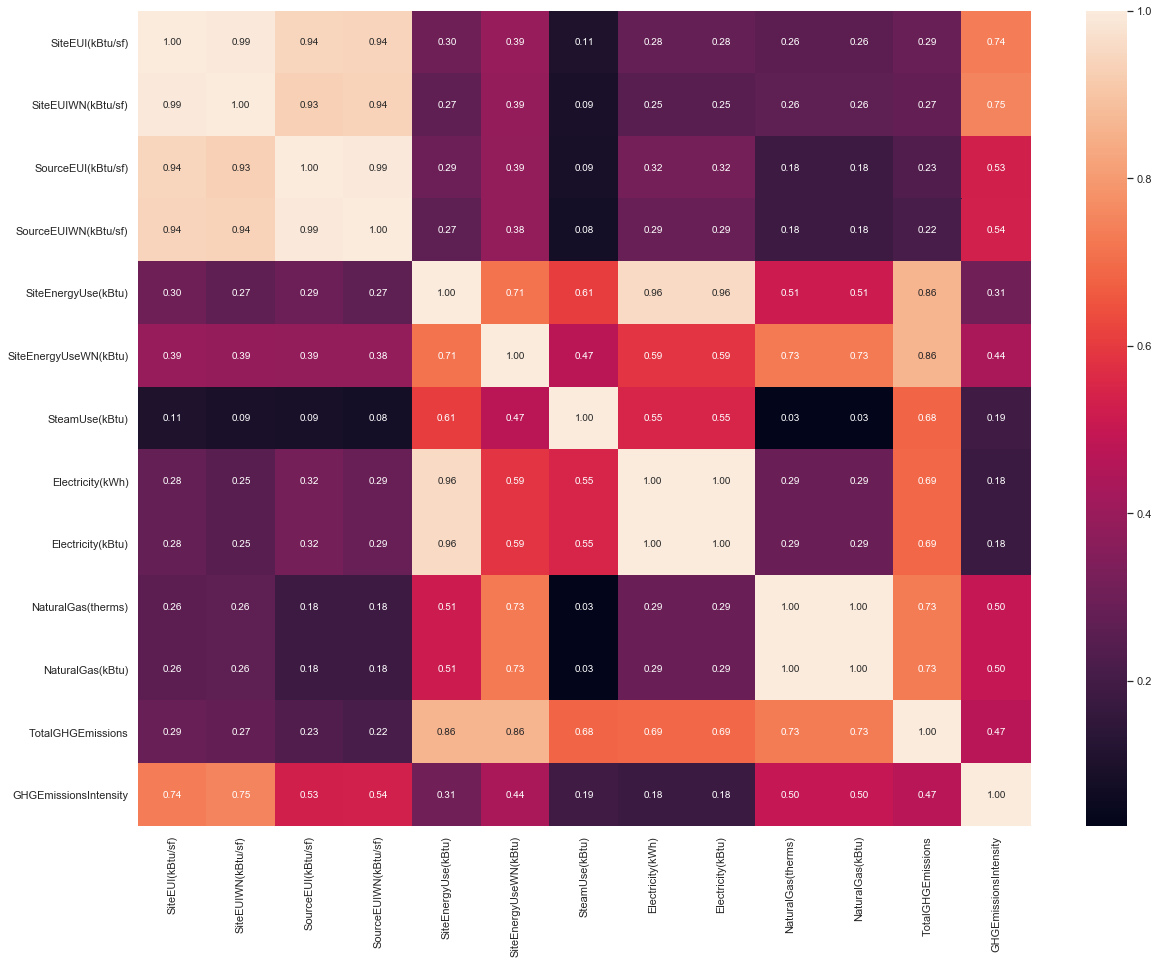

In [32]:
# on va analyser d'abord juste les colonnes énérgétiques
correlation_matrix(data_2016[['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity']])

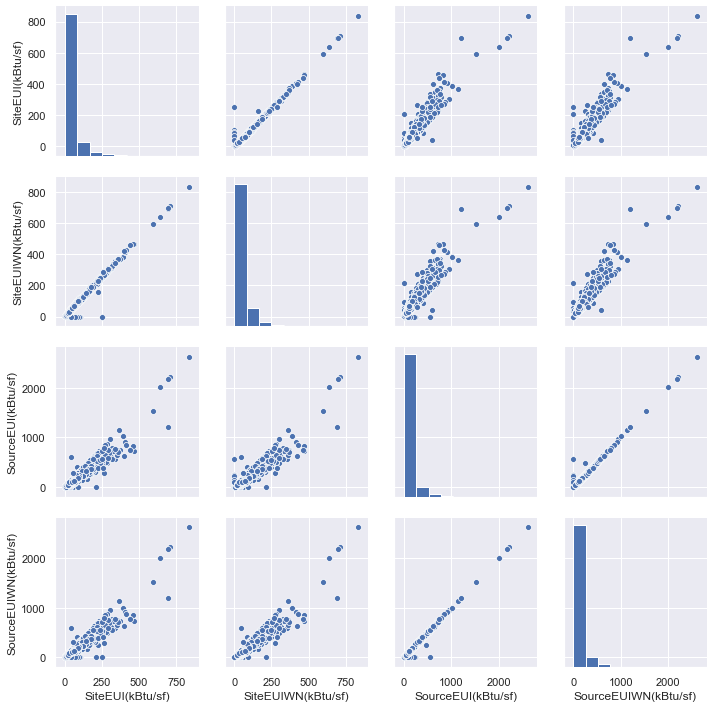

In [33]:
# certaines données semblent fortement corrélées, commençons par analyser la corrélation des données d'intensité énérgétiques
sns.pairplot(data_2016[['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']])

In [34]:
def test_correlation(X, Y, color, df):
    # on fait un test du chi2 pour voir si mes variables sont corrélées
    correl_data=df[[X, Y]]
    correl_data.dropna(inplace=True)
    cont = correl_data.pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).copy().astype(int)
    st_chi2, st_p, st_dof, st_exp = chi2_contingency(cont)

    print('{f1} vs {f2} : Stat du chi2 = {chi2}, degrès de liberté = {deg}, P value = {p}'.format(f1=X, f2=Y, p=st_p, chi2=st_chi2, deg=st_dof))
    # Essayons de voir si les données sont corrélées en calculant la corrélation linéaire de pearson

    print('%s vs %s : Corrélation = %0.2f' % (X, Y, df[X].corr(df[Y], method='pearson')))
    
    df.plot(x=X, y=Y, style=color + 'o', figsize=[15, 15])

SiteEUI(kBtu/sf) vs SiteEUIWN(kBtu/sf) : Stat du chi2 = 1821459.5315073961, degrès de liberté = 1150166, P value = 0.0
SiteEUI(kBtu/sf) vs SiteEUIWN(kBtu/sf) : Corrélation = 0.99


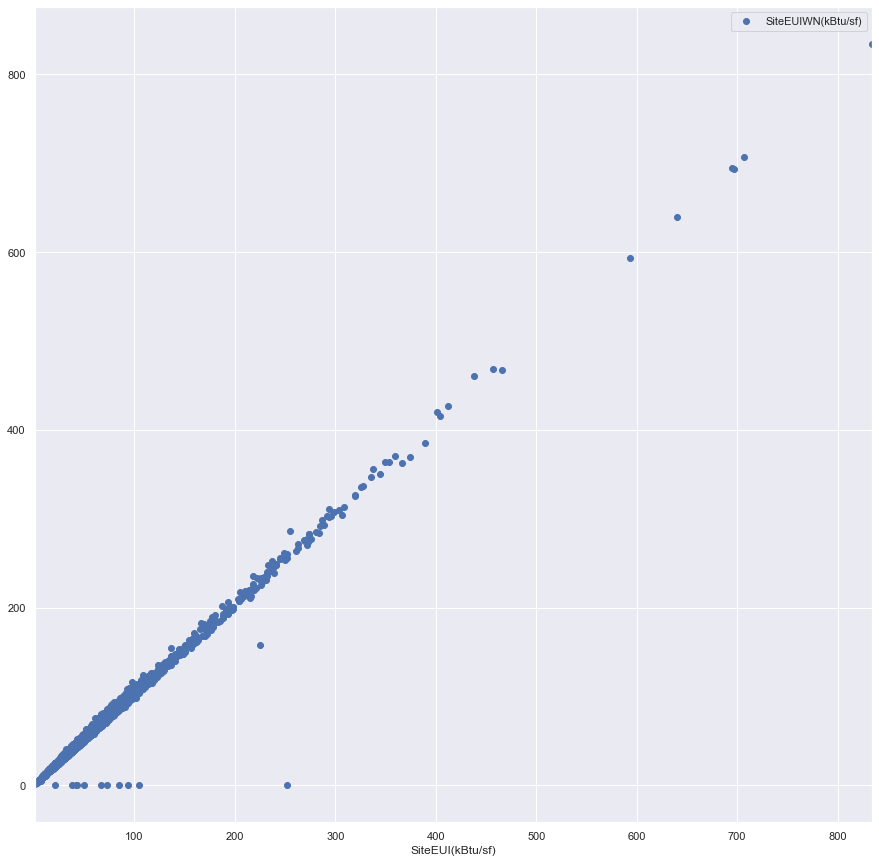

In [35]:
test_correlation('SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', color='b', df=data_2016)

SiteEUI(kBtu/sf) vs SourceEUI(kBtu/sf) : Stat du chi2 = 2323336.4046969796, degrès de liberté = 1716745, P value = 0.0
SiteEUI(kBtu/sf) vs SourceEUI(kBtu/sf) : Corrélation = 0.94


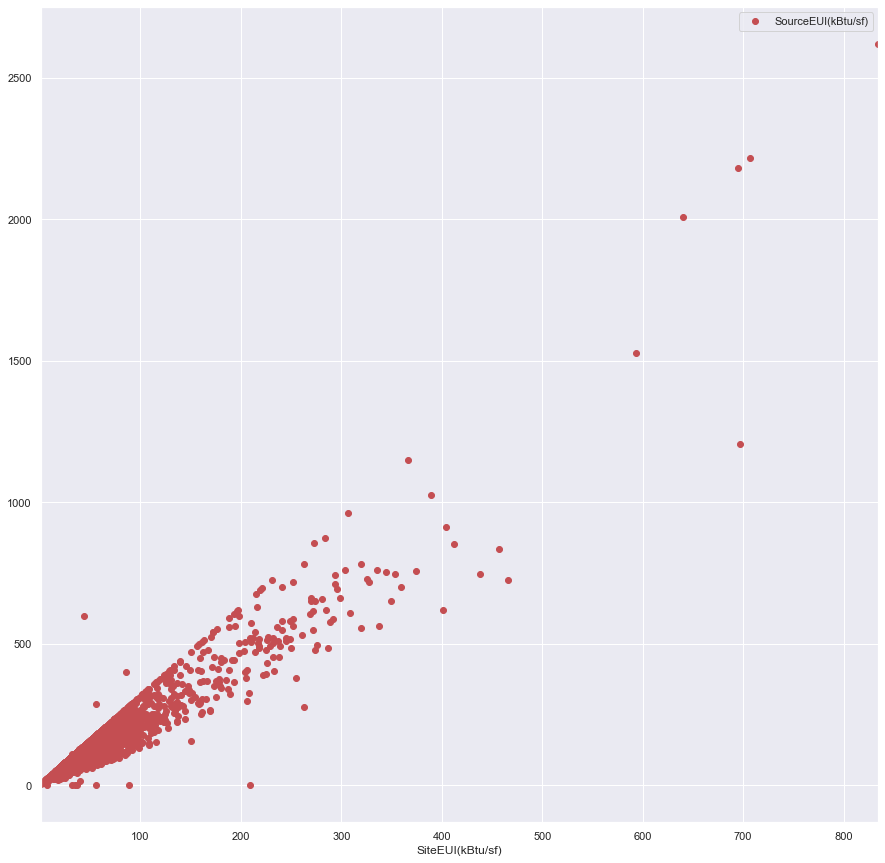

In [36]:
test_correlation('SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', color='r', df=data_2016)

SiteEUI(kBtu/sf) vs SourceEUIWN(kBtu/sf) : Stat du chi2 = 2297342.8690314903, degrès de liberté = 1759265, P value = 0.0
SiteEUI(kBtu/sf) vs SourceEUIWN(kBtu/sf) : Corrélation = 0.94


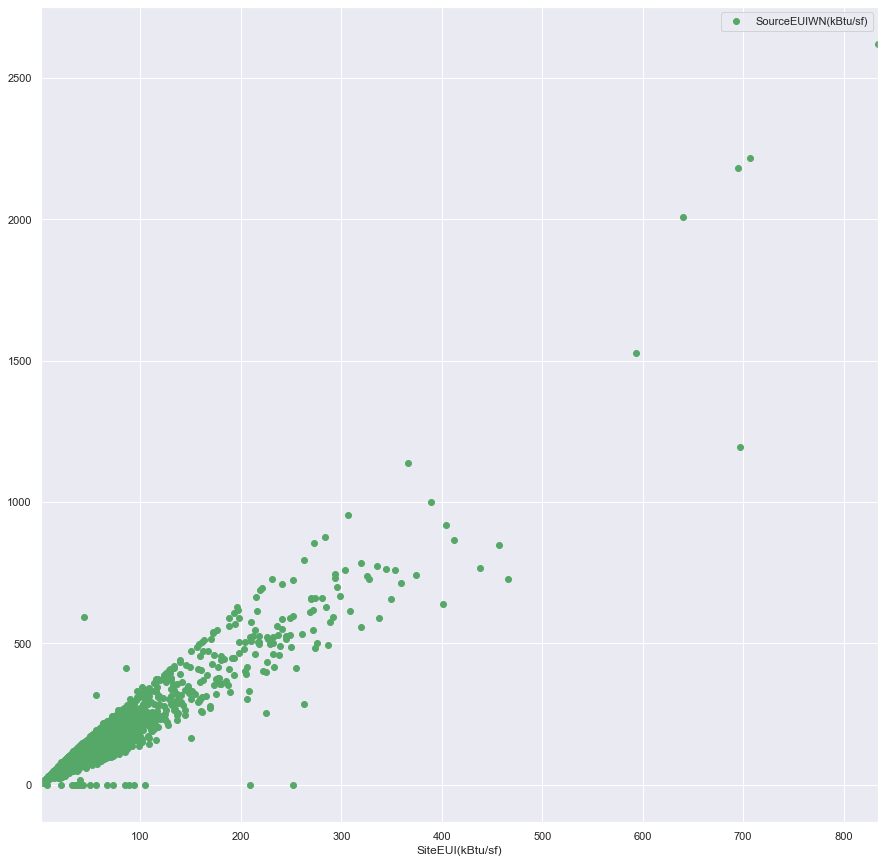

In [37]:
test_correlation('SiteEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', color='g', df=data_2016)

Comme les variables d'intensité énérgétique sont très corrélées on va garder que SiteEUIWN(kBtu/sf)

In [38]:
eui_columns = ['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']
data_2016.drop(columns=eui_columns, inplace=True)
data_2015.drop(columns=eui_columns, inplace=True)

On fait la même analyse sur l'énergie

SiteEnergyUse(kBtu) vs SiteEnergyUseWN(kBtu) : Stat du chi2 = 10268789.999999981, degrès de liberté = 10265591, P value = 0.24006982552530207
SiteEnergyUse(kBtu) vs SiteEnergyUseWN(kBtu) : Corrélation = 0.71


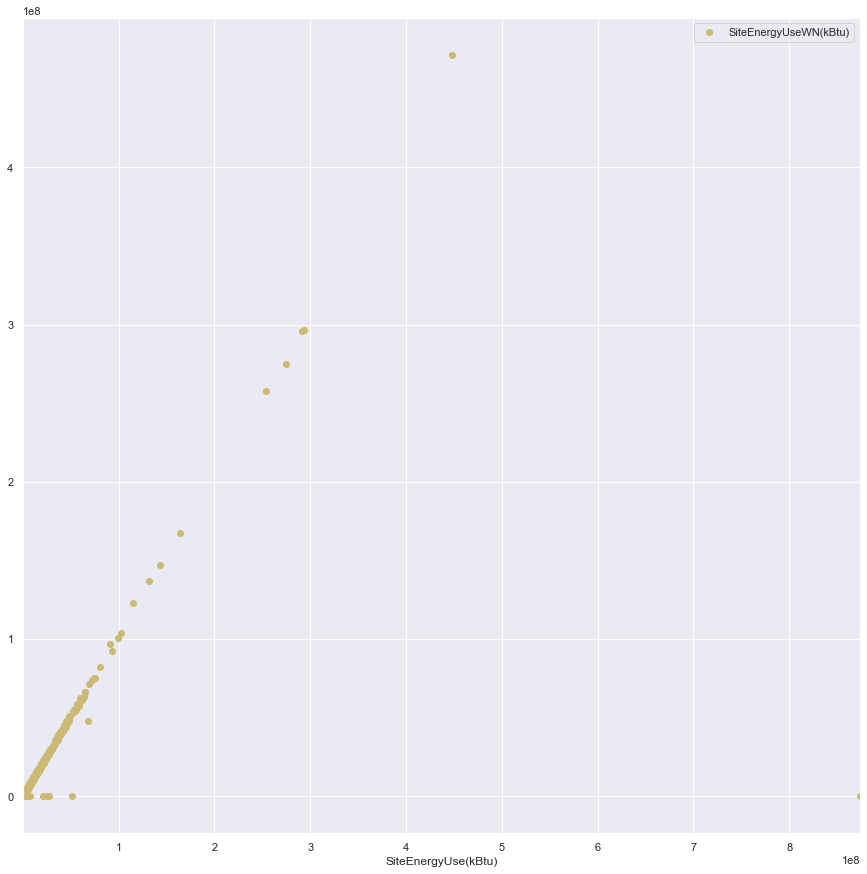

In [39]:
test_correlation('SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', color='y', df=data_2016)

In [40]:
energy_columns = ['SiteEnergyUse(kBtu)']
data_2016.drop(columns=energy_columns, inplace=True)
data_2015.drop(columns=energy_columns, inplace=True)

Electricity(kWh) vs Electricity(kBtu) : Stat du chi2 = 10265606.999999939, degrès de liberté = 10249602, P value = 0.00020521046262973684
Electricity(kWh) vs Electricity(kBtu) : Corrélation = 1.00


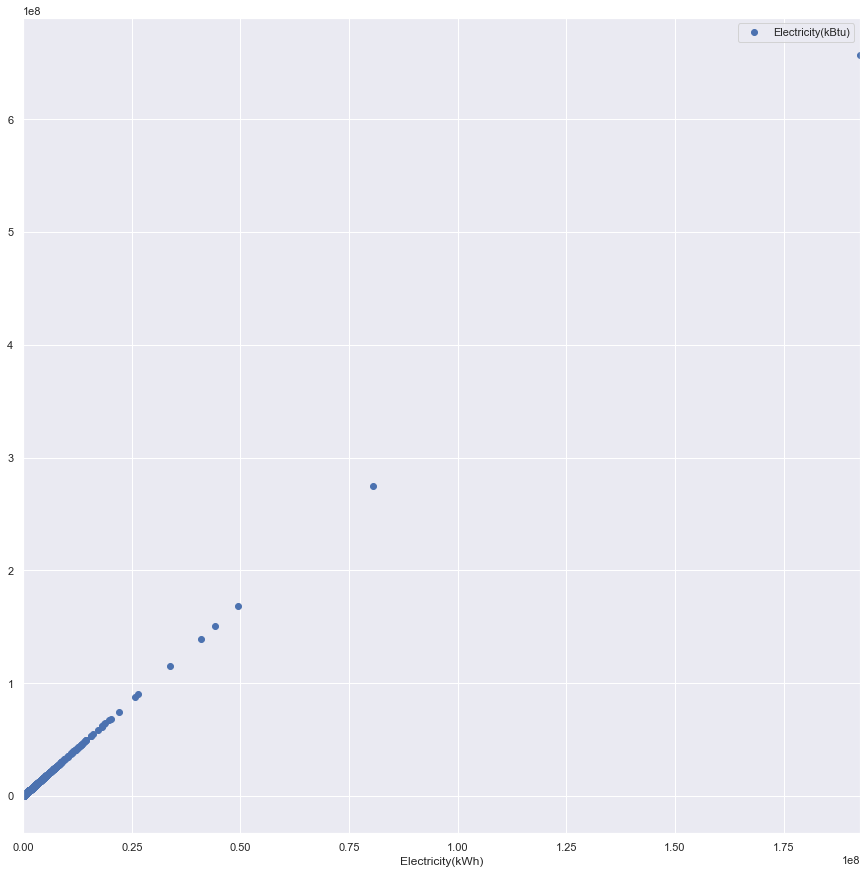

In [41]:
test_correlation('Electricity(kWh)', 'Electricity(kBtu)', color='b', df=data_2016)

Les données éléctriques sont très corrélées uaussi, on va garder que la colonne en kBtu pour rester cohérent avec le reste du nettoyage

In [42]:
elec_columns = ['Electricity(kWh)']
data_2016.drop(columns=elec_columns, inplace=True)
data_2015.drop(columns=elec_columns, inplace=True)

On va faire la même analyse aussi pour le Gaz naturel

NaturalGas(therms) vs NaturalGas(kBtu) : Stat du chi2 = 6439655.999999963, degrès de liberté = 4032064, P value = 0.0
NaturalGas(therms) vs NaturalGas(kBtu) : Corrélation = 1.00


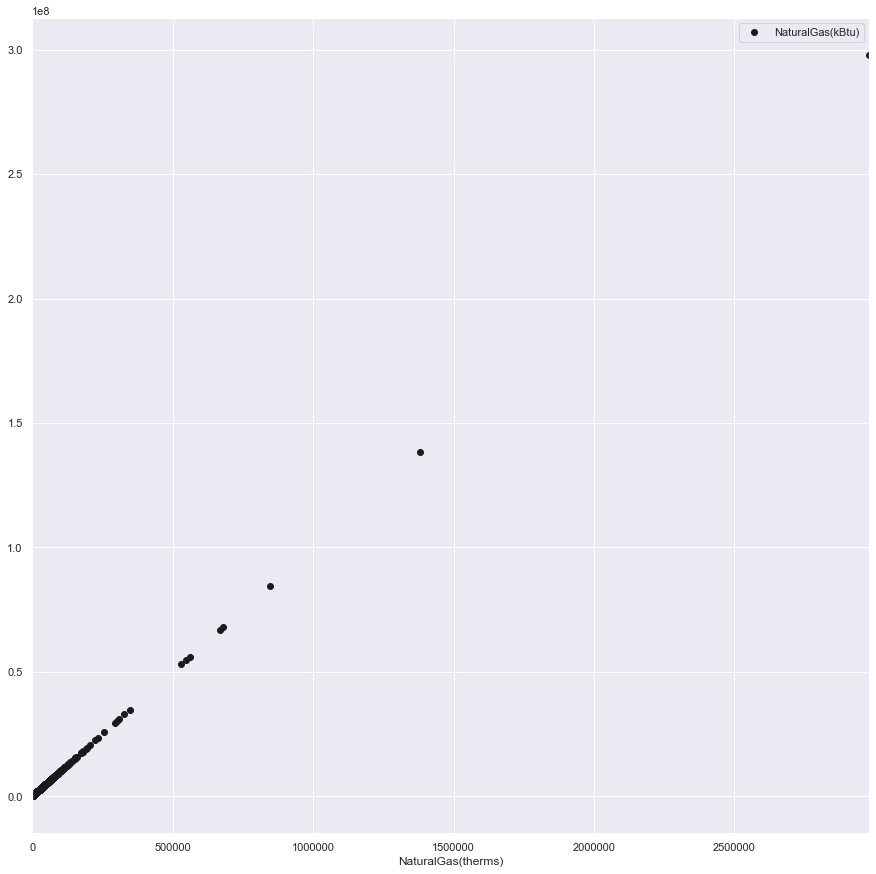

In [43]:
test_correlation('NaturalGas(therms)', 'NaturalGas(kBtu)', color='k', df=data_2016)

Et comme les données sont fortement corrélées on peut en garder une seule

In [44]:
natural_cols = ['NaturalGas(therms)']
data_2016.drop(columns=natural_cols, inplace=True)
data_2015.drop(columns=natural_cols, inplace=True)

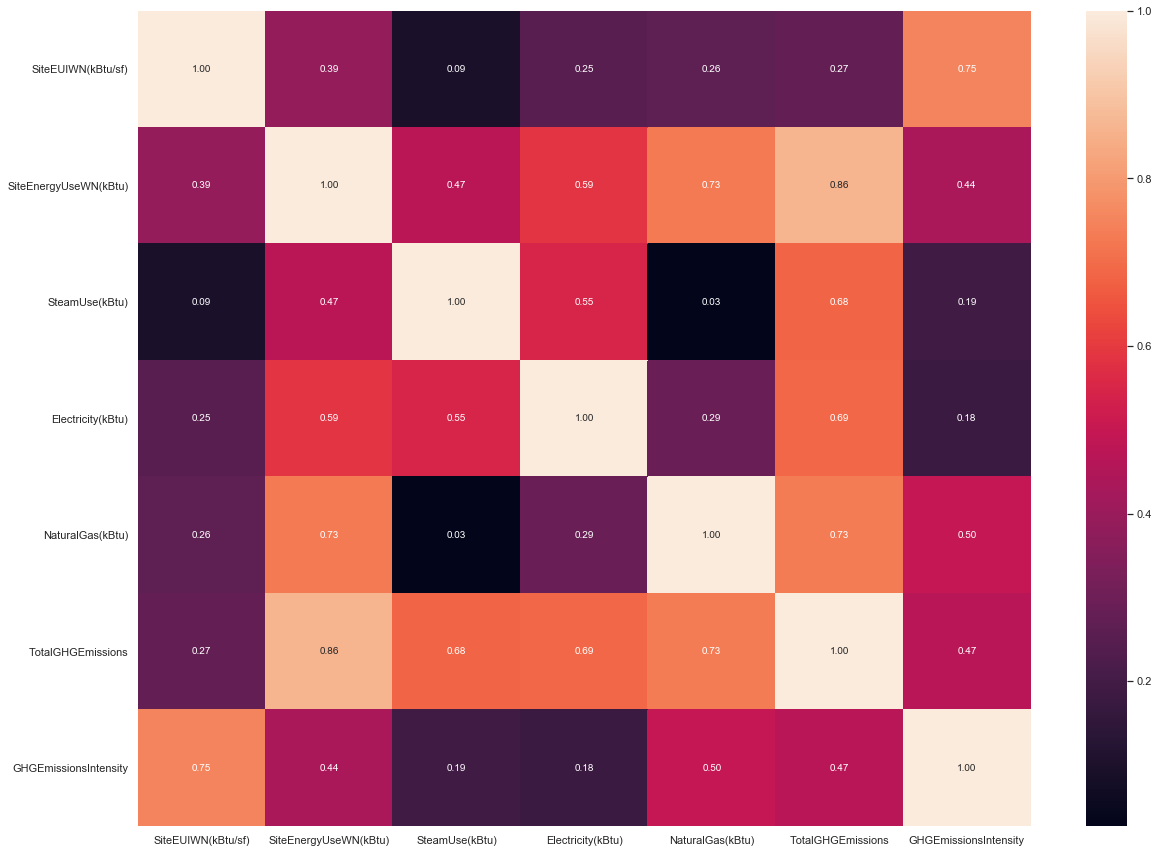

In [45]:
correlation_matrix(data_2016[['SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)','TotalGHGEmissions',
       'GHGEmissionsIntensity']])

On va transformer les colonnes en category si nécessaire, pour voir la corrélation entre ces différentes catégories

In [46]:
categorical_columns = ['BuildingType', 
                       'PrimaryPropertyType', 
                       'CouncilDistrictCode', 
                       'Neighborhood', 
                       'LargestPropertyUseType', 
                       'ZipCode']
for col in categorical_columns:
    data_2015[col] = data_2015[col].astype('category')
    data_2016[col] = data_2016[col].astype('category')

data_2016.dtypes

BuildingType                 category
PrimaryPropertyType          category
ZipCode                      category
CouncilDistrictCode          category
Neighborhood                 category
NumberofBuildings             float64
NumberofFloors                  int64
PropertyGFATotal                int64
PropertyGFAParking              int64
PropertyGFABuilding(s)          int64
LargestPropertyUseType       category
LargestPropertyUseTypeGFA     float64
ENERGYSTARScore               float64
SiteEUIWN(kBtu/sf)            float64
SiteEnergyUseWN(kBtu)         float64
SteamUse(kBtu)                float64
Electricity(kBtu)             float64
NaturalGas(kBtu)              float64
TotalGHGEmissions             float64
GHGEmissionsIntensity         float64
Building Age                    int64
dtype: object

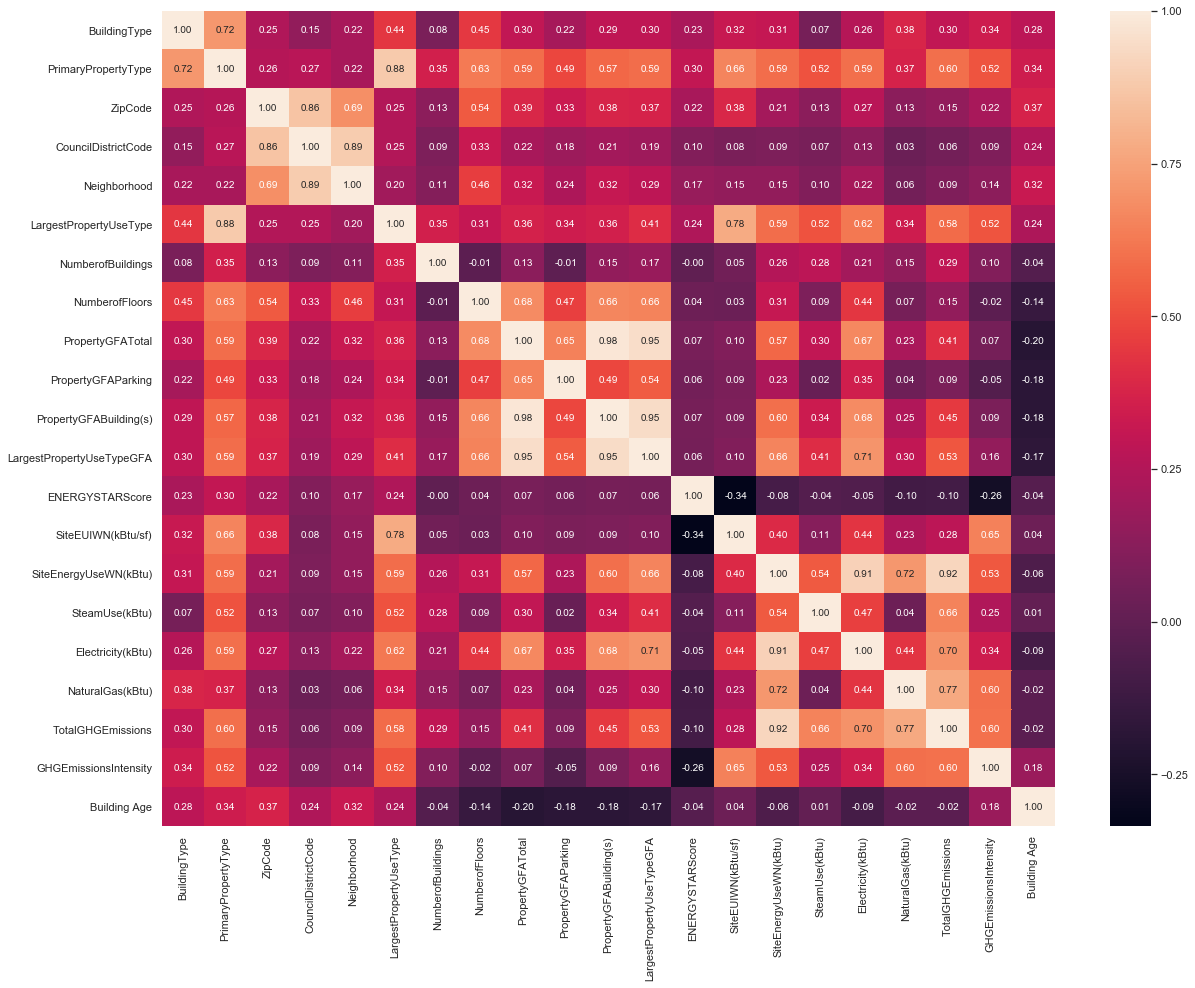

In [47]:
correlation_matrix(data_2016)

In [48]:
# on voit que les colonnes ZipCode, neighborhood et Councildistrictcode sont fortement corrélées, 
# on va garder ue le Council district code
location_columns = ['ZipCode', 'Neighborhood']
data_2016.drop(columns=location_columns, inplace=True)
data_2015.drop(columns=location_columns, inplace=True)

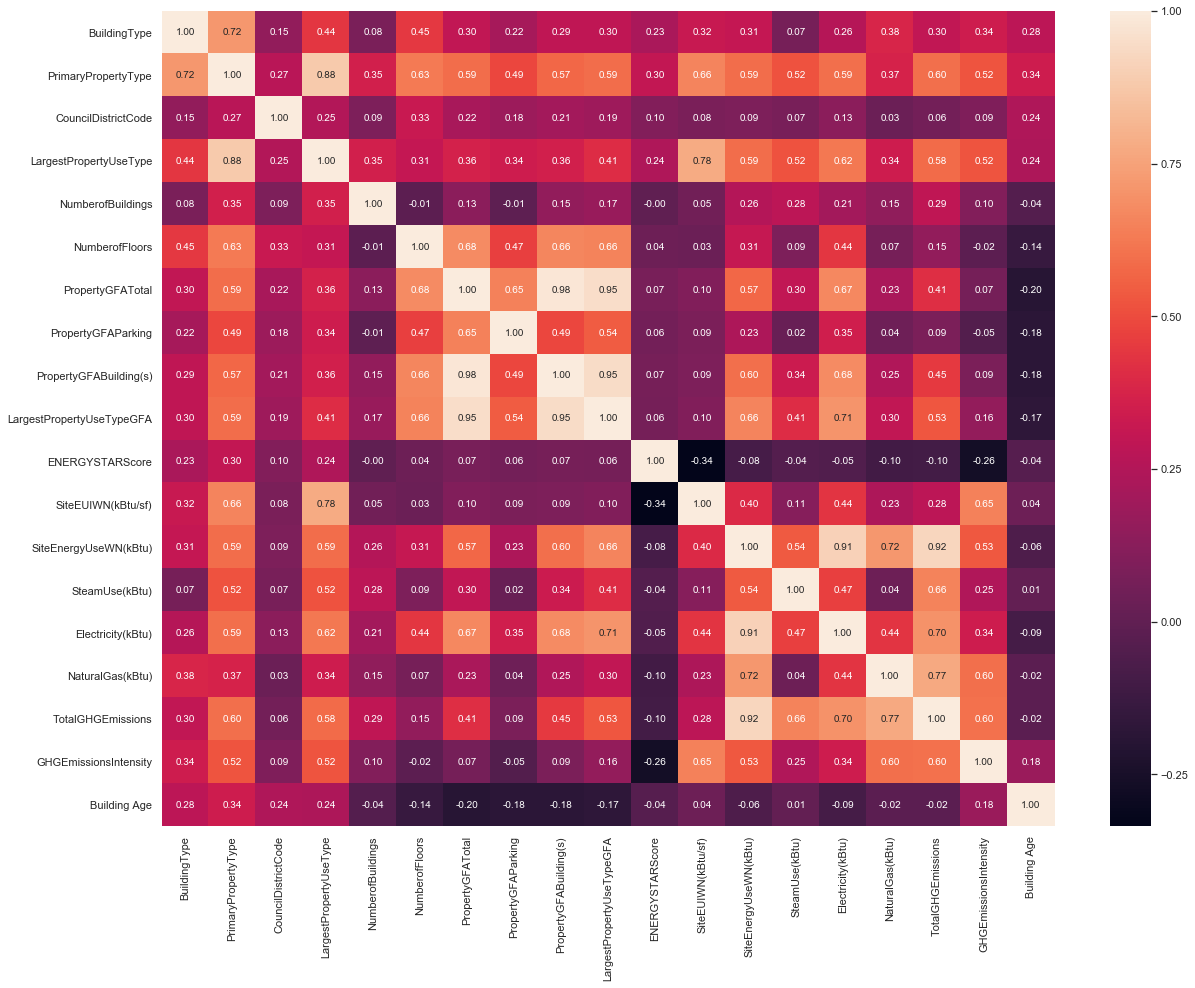

In [49]:
correlation_matrix(data_2016)

In [50]:
# Aures données corrélées avec le LargestPropertyUseTypeGFA ou avec le PrimaryPropertyType
metadata_columns = ['BuildingType', 'PropertyGFATotal', 'PropertyGFABuilding(s)']
data_2016.drop(columns=metadata_columns, inplace=True)
data_2015.drop(columns=metadata_columns, inplace=True)

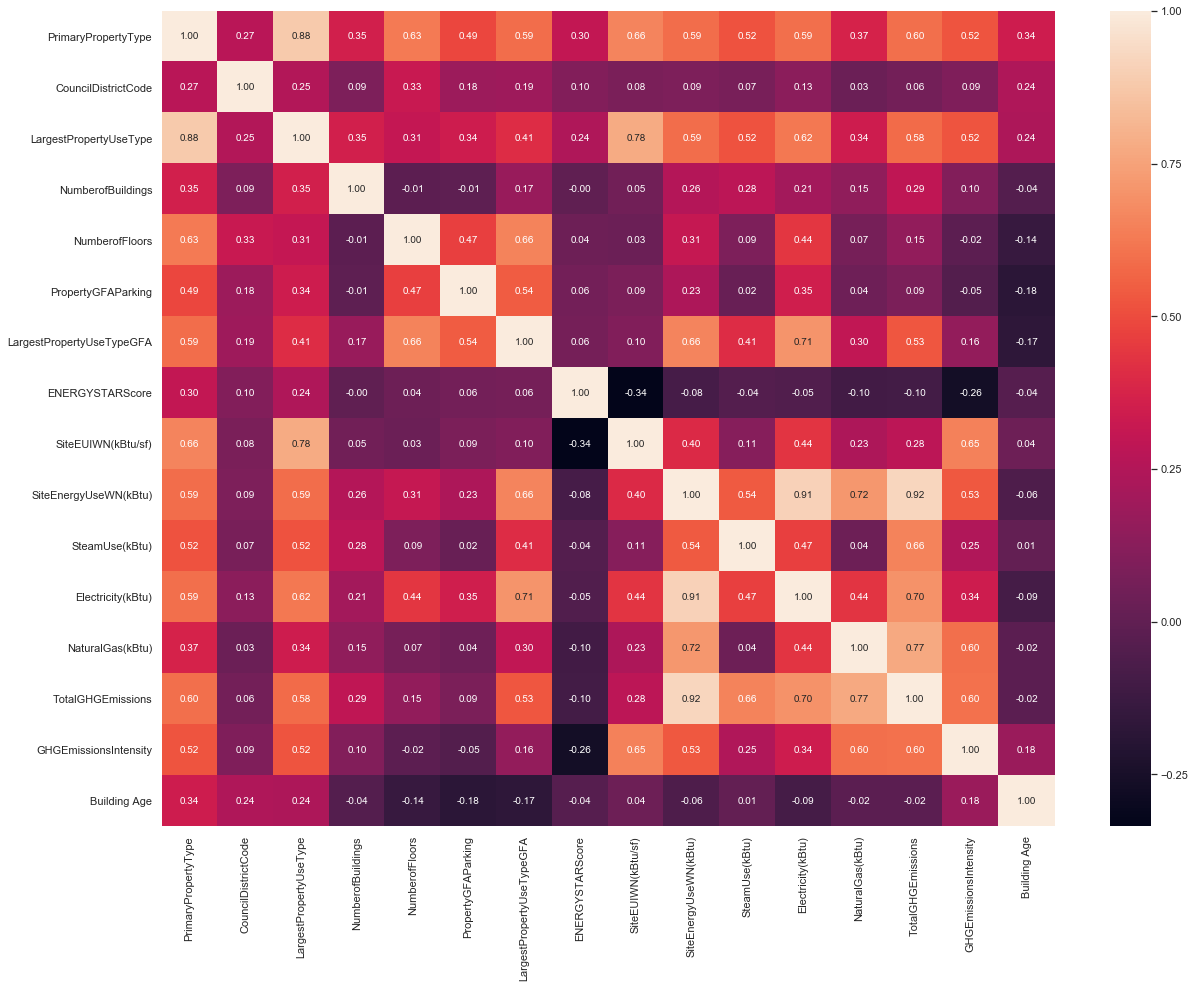

In [51]:
correlation_matrix(data_2016)

In [52]:
# On remarque que le PrimaryPropertyType est très corrélé avec le LargestProperrtyUseType

data_2016.drop(columns=['PrimaryPropertyType'], inplace=True)
data_2015.drop(columns=['PrimaryPropertyType'], inplace=True)

In [53]:
# Malheureusement on peut pas utiliser les colonnes d'intensité énérgétique, le but étant de prédide la consommation en 
# énérgie et les émissions de CO2,  donc on va les retirer
data_2016.drop(columns=['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity'], inplace=True)
data_2015.drop(columns=['SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity'], inplace=True)

On n'a pas le droit d'utiliser la quantité émise de gaz naturel, d'électricité .. 
Mais on suppose qu'on peut utiliser si le building émet du Gaz, de l'éléctricité ... donc on va utiliser des nouvelles colonnes 
comportant des binaires 1 ou 0 pour ça 

In [54]:
def convert_to_binary(row, feature):
    value = row[feature]
    if not isinstance(value, float) or np.isnan(value):
        return 0
    if value > 0:
        return 1
    return 0

energy_columns_mapping = {'SteamUse(kBtu)' : 'Has steam', 
                          'Electricity(kBtu)': 'Has electricity', 
                          'NaturalGas(kBtu)': 'Has natural gaz'}
for col, new_name in energy_columns_mapping.items():
    data_2016 = data_2016[data_2016[col] >= 0] # on ignore les valeurs négatives qui sont des outliers
    data_2015 = data_2015[data_2015[col] >= 0]
    
    data_2016[new_name] = data_2016.apply(lambda row : convert_to_binary(row, col), axis=1)
    data_2015[new_name] = data_2015.apply(lambda row : convert_to_binary(row, col), axis=1)

data_2016.drop(columns=energy_columns_mapping.keys(), inplace=True)
data_2015.drop(columns=energy_columns_mapping.keys(), inplace=True)

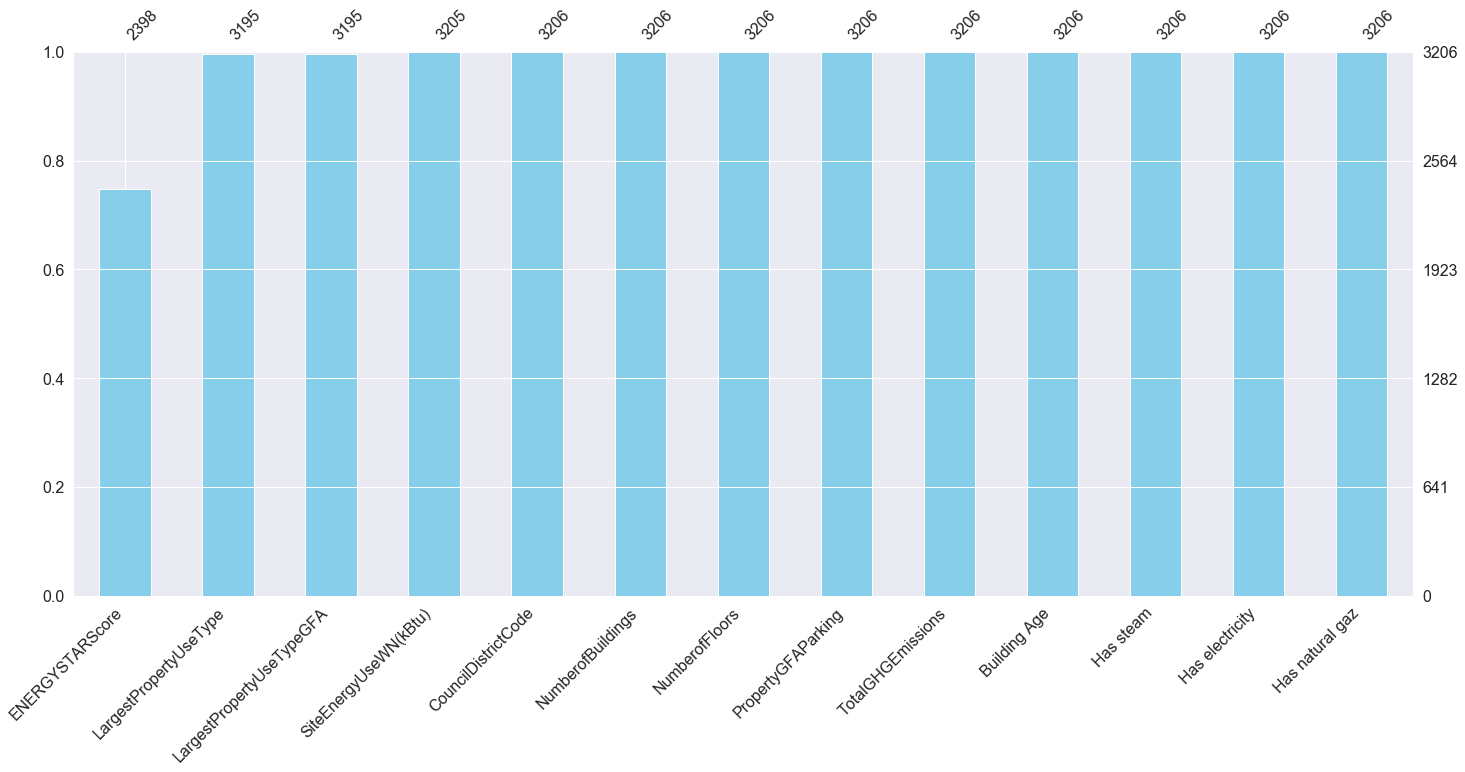

In [55]:
msno.bar(data_2016, sort='ascending', color='skyblue')

le largest property use type, et use type gfa, sont des inputs mportants pour prédire les émissions de CO2 et la consommation d'énérgie, on garde que les valeurs non nulles
Pareil, le SiteEnergyUseWN est la valeur à prédire, on devrait garder que les valeurs non nulles

In [56]:
data_2016.dropna(subset=['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SiteEnergyUseWN(kBtu)'], how='any', inplace=True)
data_2015.dropna(subset=['LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SiteEnergyUseWN(kBtu)'], how='any', inplace=True)

### Normalisation des données

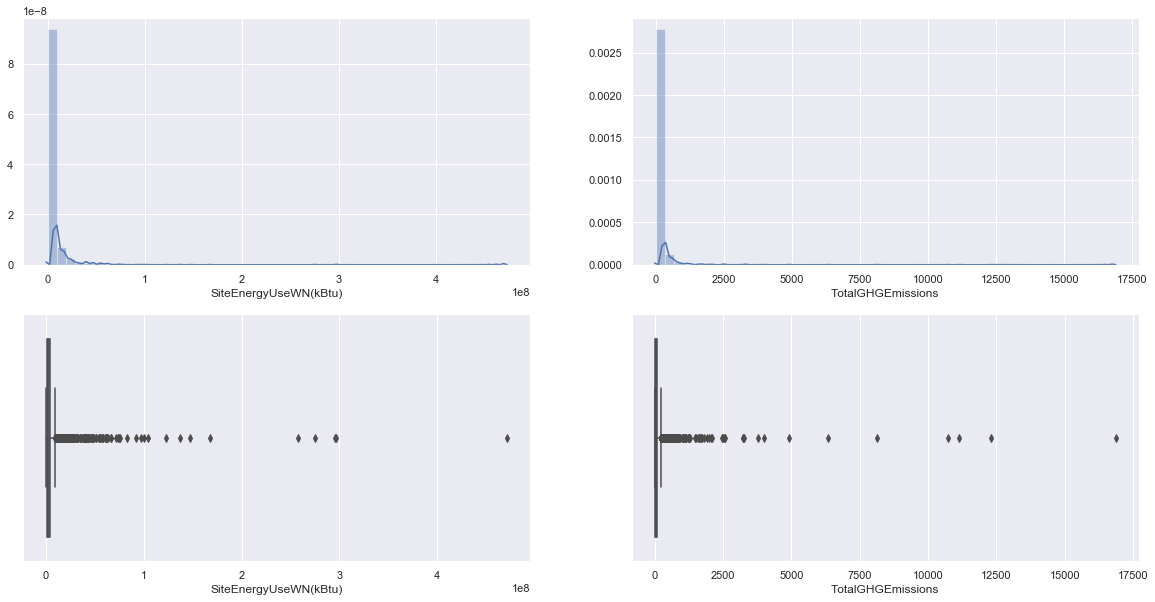

In [57]:
# on va donc chercher à prédire SiteEnergyUseWN(kBtu) et TotalGHGEmissions et ENERGYSTARScore
data = data_2016.dropna(subset=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'], how='any')
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(data['SiteEnergyUseWN(kBtu)'],ax=axes[0][0])
sns.distplot(data['TotalGHGEmissions'],ax=axes[0][1])
sns.boxplot(data['SiteEnergyUseWN(kBtu)'],ax=axes[1][0])
sns.boxplot(data['TotalGHGEmissions'],ax=axes[1][1])

On transforme les données en log, pour avoir  une meilleure distribution des données

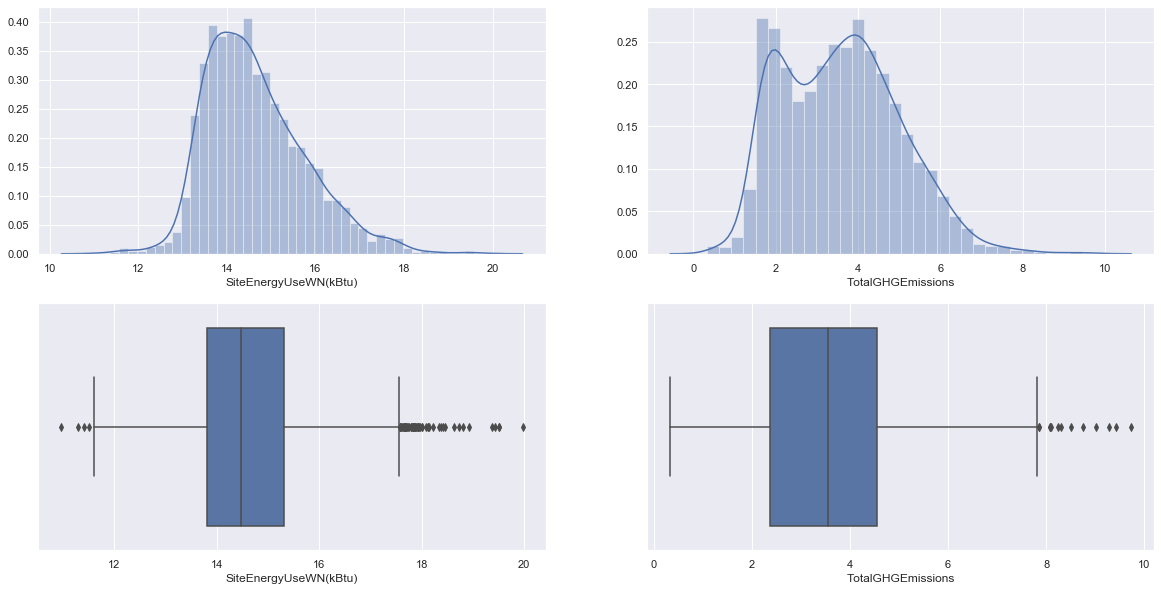

In [58]:
data = data[data['TotalGHGEmissions'] > 0]
data = data[data['SiteEnergyUseWN(kBtu)'] > 0]

data_log = data.copy(deep=True)
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)

data_log['SiteEnergyUseWN(kBtu)'] =  np.log(data_log['SiteEnergyUseWN(kBtu)'] + 1)
data_log['TotalGHGEmissions'] =  np.log(data_log['TotalGHGEmissions'] + 1)


sns.distplot(data_log['SiteEnergyUseWN(kBtu)'],ax=axes[0][0])
sns.distplot(data_log['TotalGHGEmissions'],ax=axes[0][1])
sns.boxplot(data_log['SiteEnergyUseWN(kBtu)'],ax=axes[1][0])
sns.boxplot(data_log['TotalGHGEmissions'],ax=axes[1][1])

L'utilisation d'énérgie peut mériter un test de sharpiro pour voir si ça suit une loi normale

In [59]:
from scipy.stats import shapiro
shapiro(data_log['SiteEnergyUseWN(kBtu)'])

(0.9637747406959534, 1.5351182178457363e-27)

In [60]:
# On rejette la  normalité de cette feature, mais on transforme quand même les données en log 
def transform_to_log(data, feature, lda=None):
    data = data[data[feature] > 0]
    data[feature] =  np.log(data[feature] + 1)        
    return data

data_2016 = transform_to_log(data_2016, 'TotalGHGEmissions')
data_2015 = transform_to_log(data_2015, 'TotalGHGEmissions')

data_2016 = transform_to_log(data_2016, 'SiteEnergyUseWN(kBtu)')
data_2015 = transform_to_log(data_2015, 'SiteEnergyUseWN(kBtu)')

data_2016.head(5)

,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Building Age,Has steam,Has electricity,Has natural gaz
0,7,1.0,12,0,Hotel,88434.0,60.0,15.824652,5.525373,89,1,1,1
1,7,1.0,11,15064,Hotel,83880.0,61.0,15.974742,5.693261,20,0,1,1
2,7,1.0,41,196718,Hotel,756493.0,43.0,18.118725,7.645053,47,1,1,1
3,7,1.0,10,0,Hotel,61320.0,56.0,15.753792,5.660979,90,1,1,1
4,7,1.0,18,62000,Hotel,123445.0,75.0,16.500395,6.226556,36,0,1,1


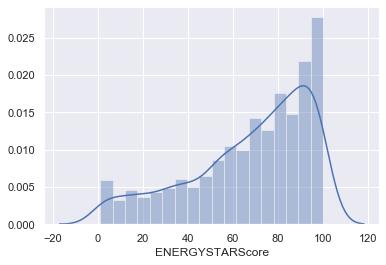

In [61]:
# pour l'energie score:
data = data_2016.dropna(subset=['ENERGYSTARScore'], how='any')
sns.distplot(data['ENERGYSTARScore'])


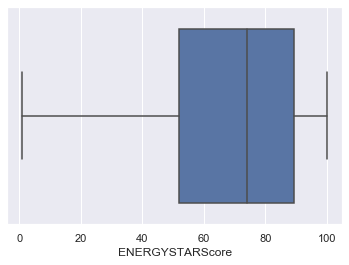

In [62]:
sns.boxplot(data['ENERGYSTARScore'])

On regarde si les données de surface doivent être changées aussi

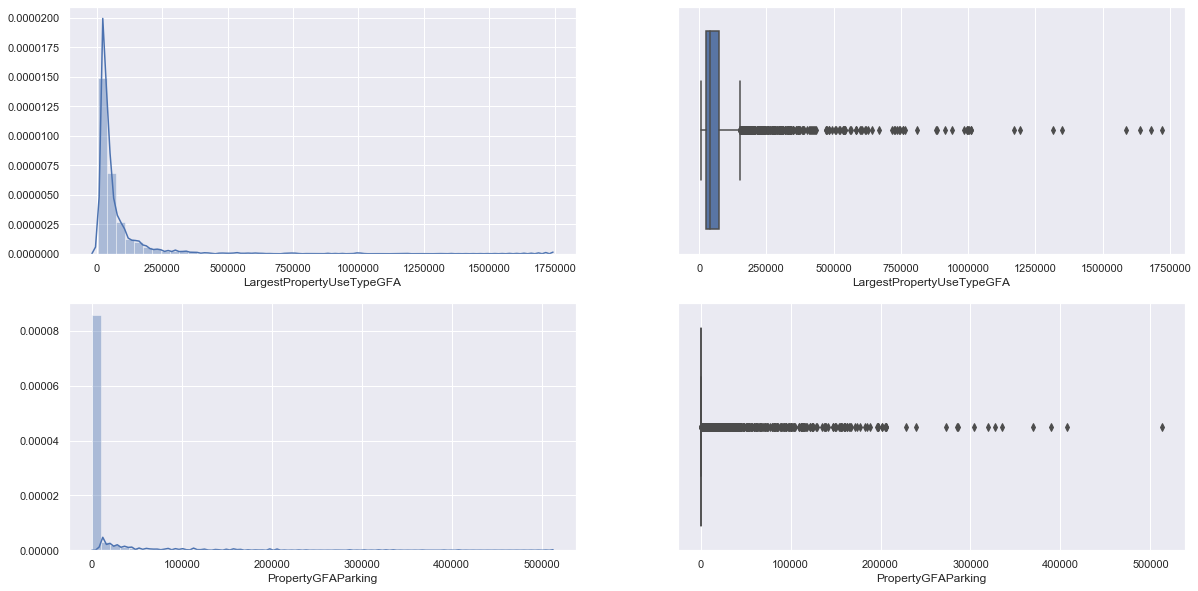

In [63]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(data_2016['LargestPropertyUseTypeGFA'],ax=axes[0][0])
sns.boxplot(data_2016['LargestPropertyUseTypeGFA'],ax=axes[0][1])
sns.distplot(data_2016['PropertyGFAParking'],ax=axes[1][0])
sns.boxplot(data_2016['PropertyGFAParking'],ax=axes[1][1])

On transforme ces données en log aussi

In [64]:
surface_columns = ['LargestPropertyUseTypeGFA','PropertyGFAParking']
for feature in surface_columns:
    data_2016[feature] = np.log(data_2016[feature] + 1)
    data_2015[feature] =  np.log(data_2015[feature] + 1)
    

(3181, 13)

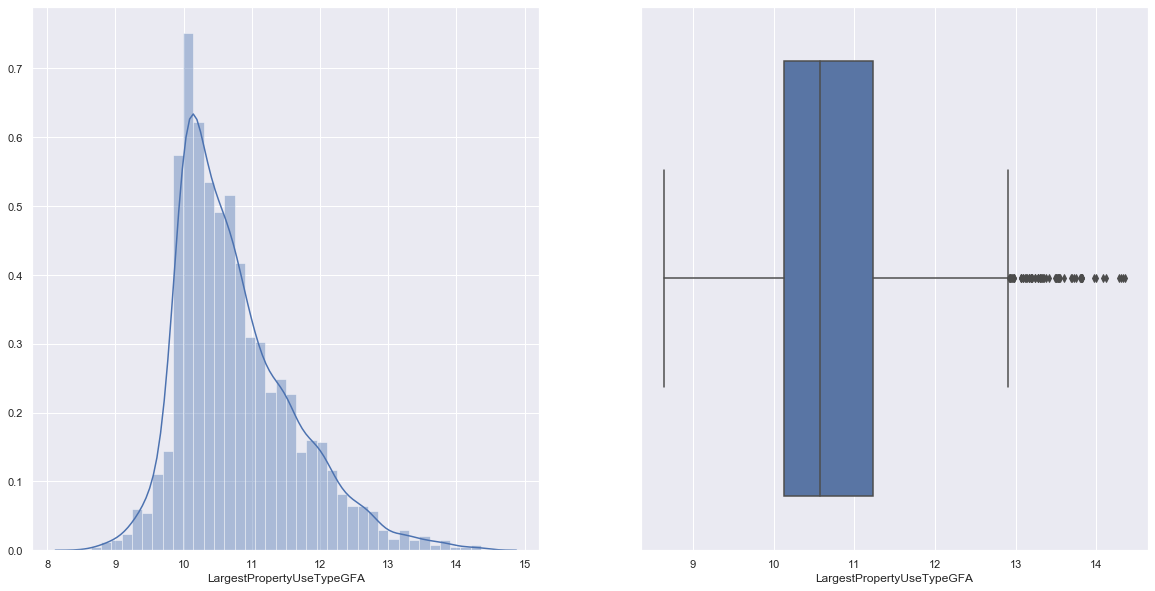

In [65]:
data = data_2016.dropna(subset=['LargestPropertyUseTypeGFA'], how='any')
fig,axes = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20, 10)
sns.distplot(data['LargestPropertyUseTypeGFA'],ax=axes[0])
sns.boxplot(data['LargestPropertyUseTypeGFA'],ax=axes[1])


data_2016.shape

On retransforme la colonne councilDistrictCode en int pour ne pas l'avoir à l'encoder 
On encode la colonne LargestPropertyUseType
Et finalement on va Standardiser toutes les données

In [66]:
data_2015['CouncilDistrictCode'] = data_2015['CouncilDistrictCode'].astype('int')
data_2016['CouncilDistrictCode'] = data_2016['CouncilDistrictCode'].astype('int')
data_2016.dtypes

CouncilDistrictCode             int32
NumberofBuildings             float64
NumberofFloors                  int64
PropertyGFAParking            float64
LargestPropertyUseType       category
LargestPropertyUseTypeGFA     float64
ENERGYSTARScore               float64
SiteEnergyUseWN(kBtu)         float64
TotalGHGEmissions             float64
Building Age                    int64
Has steam                       int64
Has electricity                 int64
Has natural gaz                 int64
dtype: object

In [67]:
# Comme expliqué plus haut, on veut prédire les données 2015 en utilisant 2016 avec le modèle final, 
# on veut utiliser un label encoder, et utiliser le meme pour 2015, on va voir les données 2015 de LargestPropertyUseTypeGFA
# qui manquent en 2016
set(data_2015['LargestPropertyUseType'].unique()) - set(data_2016['LargestPropertyUseType'].unique())

{'Convention Center', 'Outpatient Rehabilitation/Physical Therapy'}

In [68]:
data_2015[data_2015['LargestPropertyUseType'] =='Convention Center'].shape

(1, 13)

In [69]:
# il existe une seule valeur pour "Convention CEnter", pas la peine de la garder
data_2015 =data_2015[data_2015['LargestPropertyUseType'] != 'Convention Center']

In [70]:
data_2015[data_2015['LargestPropertyUseType'] =='Outpatient Rehabilitation/Physical Therapy'].shape

(1, 13)

In [71]:
# pareil pour 'Outpatient Rehabilitation/Physical Therapy'
data_2015 =data_2015[data_2015['LargestPropertyUseType'] != 'Outpatient Rehabilitation/Physical Therapy']

In [72]:
# On encode la colonne LargestPropertyUseType
enc = LabelEncoder()
enc.fit(data_2016['LargestPropertyUseType'])
data_2016['LargestPropertyUseType'] = enc.transform(data_2016['LargestPropertyUseType'])
data_2015['LargestPropertyUseType'] = enc.transform(data_2015['LargestPropertyUseType'])

Finalement on standardise les données, avec le meme StandardScaler

In [73]:
scaler = StandardScaler()
X_numeric = data_2016[list(data_2016.select_dtypes(include=[np.number]).columns.values)]
scaler.fit(X_numeric)
df_scaled = pd.DataFrame(scaler.transform(X_numeric),columns = X_numeric.columns)
data_2016_transformed = pd.concat([data_2016[list(data_2016.select_dtypes(include='object').columns)], df_scaled], axis=1)

In [74]:
X_numeric = data_2015[list(data_2015.select_dtypes(include=[np.number]).columns.values)]
df_scaled = pd.DataFrame(scaler.transform(X_numeric),columns = X_numeric.columns)
data_2015_transformed = pd.concat([data_2015[list(data_2015.select_dtypes(include='object').columns)], df_scaled], axis=1)

In [75]:
data_2015_transformed.reset_index(inplace=True)
data_2016_transformed.reset_index(inplace=True)

data_2015_transformed.to_feather('data/data_2015_cleaned.ft')
data_2016_transformed.to_feather('data/data_2016_cleaned.ft')